In [50]:
import numpy as np
import matplotlib.pyplot as plt
from heapq import heappush, heappop


def gaussian_pulse(x, mu, sigma):
    """Create a Gaussian pulse"""
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2)
def generate_sharp_wave_ripple(
    duration=1.0,
    fs=1000,
    ripple_freq=150,
    sw_sigma=0.03,
    noise_level=0.1,
    n_samples=None
):
    if n_samples is None:
        n_samples = int(fs * duration)
    t = np.linspace(0, duration, n_samples)
    
    center = duration / 2
    sharp_wave = gaussian_pulse(t, center, sw_sigma)
    sharp_wave = sharp_wave / np.max(sharp_wave)
    
    ripple = np.sin(2 * np.pi * ripple_freq * t)
    ripple_modulated = ripple * sharp_wave
    noise = noise_level * np.random.randn(len(t))
    
    swr = sharp_wave + ripple_modulated + noise
    
    # Calculate effective width (where amplitude > threshold)
    threshold = 0.1  # Adjust this to change what counts as "overlap"
    effective_width = np.where(sharp_wave > threshold)[0]
    width_samples = effective_width[-1] - effective_width[0]
    
    return t, swr, width_samples

def generate_dense_swrs(
    n_events=10,
    duration=1.0,
    fs=1000,
    min_spacing=0.02  # Minimum spacing between SWRs in seconds
):
    np.random.seed(32)
    n_samples = int(duration * fs)
    t = np.linspace(0, duration, n_samples)
    signal = np.zeros_like(t)
    
    # Get single SWR template and its width
    _, template_swr, width_samples = generate_sharp_wave_ripple(
        duration=duration,
        fs=fs,
        n_samples=n_samples
    )
    
    # Convert min_spacing to samples
    min_spacing_samples = int(min_spacing * fs)
    
    # Keep track of occupied time windows
    occupied_regions = []  # List of (start, end) tuples
    
    # Try to place all events
    successful_placements = 0
    max_attempts = n_events * 10  # Limit attempts to prevent infinite loops
    attempts = 0
    
    while successful_placements < n_events and attempts < max_attempts:
        # Generate random position
        position = np.random.randint(min_spacing_samples, n_samples - width_samples - min_spacing_samples)
        
        # Check for overlap with existing SWRs
        is_valid = True
        for start, end in occupied_regions:
            if not (position + width_samples + min_spacing_samples <= start or 
                   position >= end + min_spacing_samples):
                is_valid = False
                break
        
        if is_valid:
            # Generate new SWR with random parameters
            _, swr, _ = generate_sharp_wave_ripple(
                duration=duration,
                fs=fs,
                ripple_freq=np.random.uniform(120, 180),
                sw_sigma=np.random.uniform(0.02, 0.04),
                noise_level=0.02,
                n_samples=n_samples
            )
            
            # Add SWR to signal
            signal += np.roll(swr, position - n_samples//2)
            
            # Update occupied regions
            occupied_regions.append((position, position + width_samples))
            occupied_regions.sort()  # Keep regions sorted for efficient checking
            
            successful_placements += 1
        
        attempts += 1
    
    if successful_placements < n_events:
        print(f"Warning: Could only place {successful_placements} out of {n_events} requested SWRs")
    
    return t, signal, successful_placements


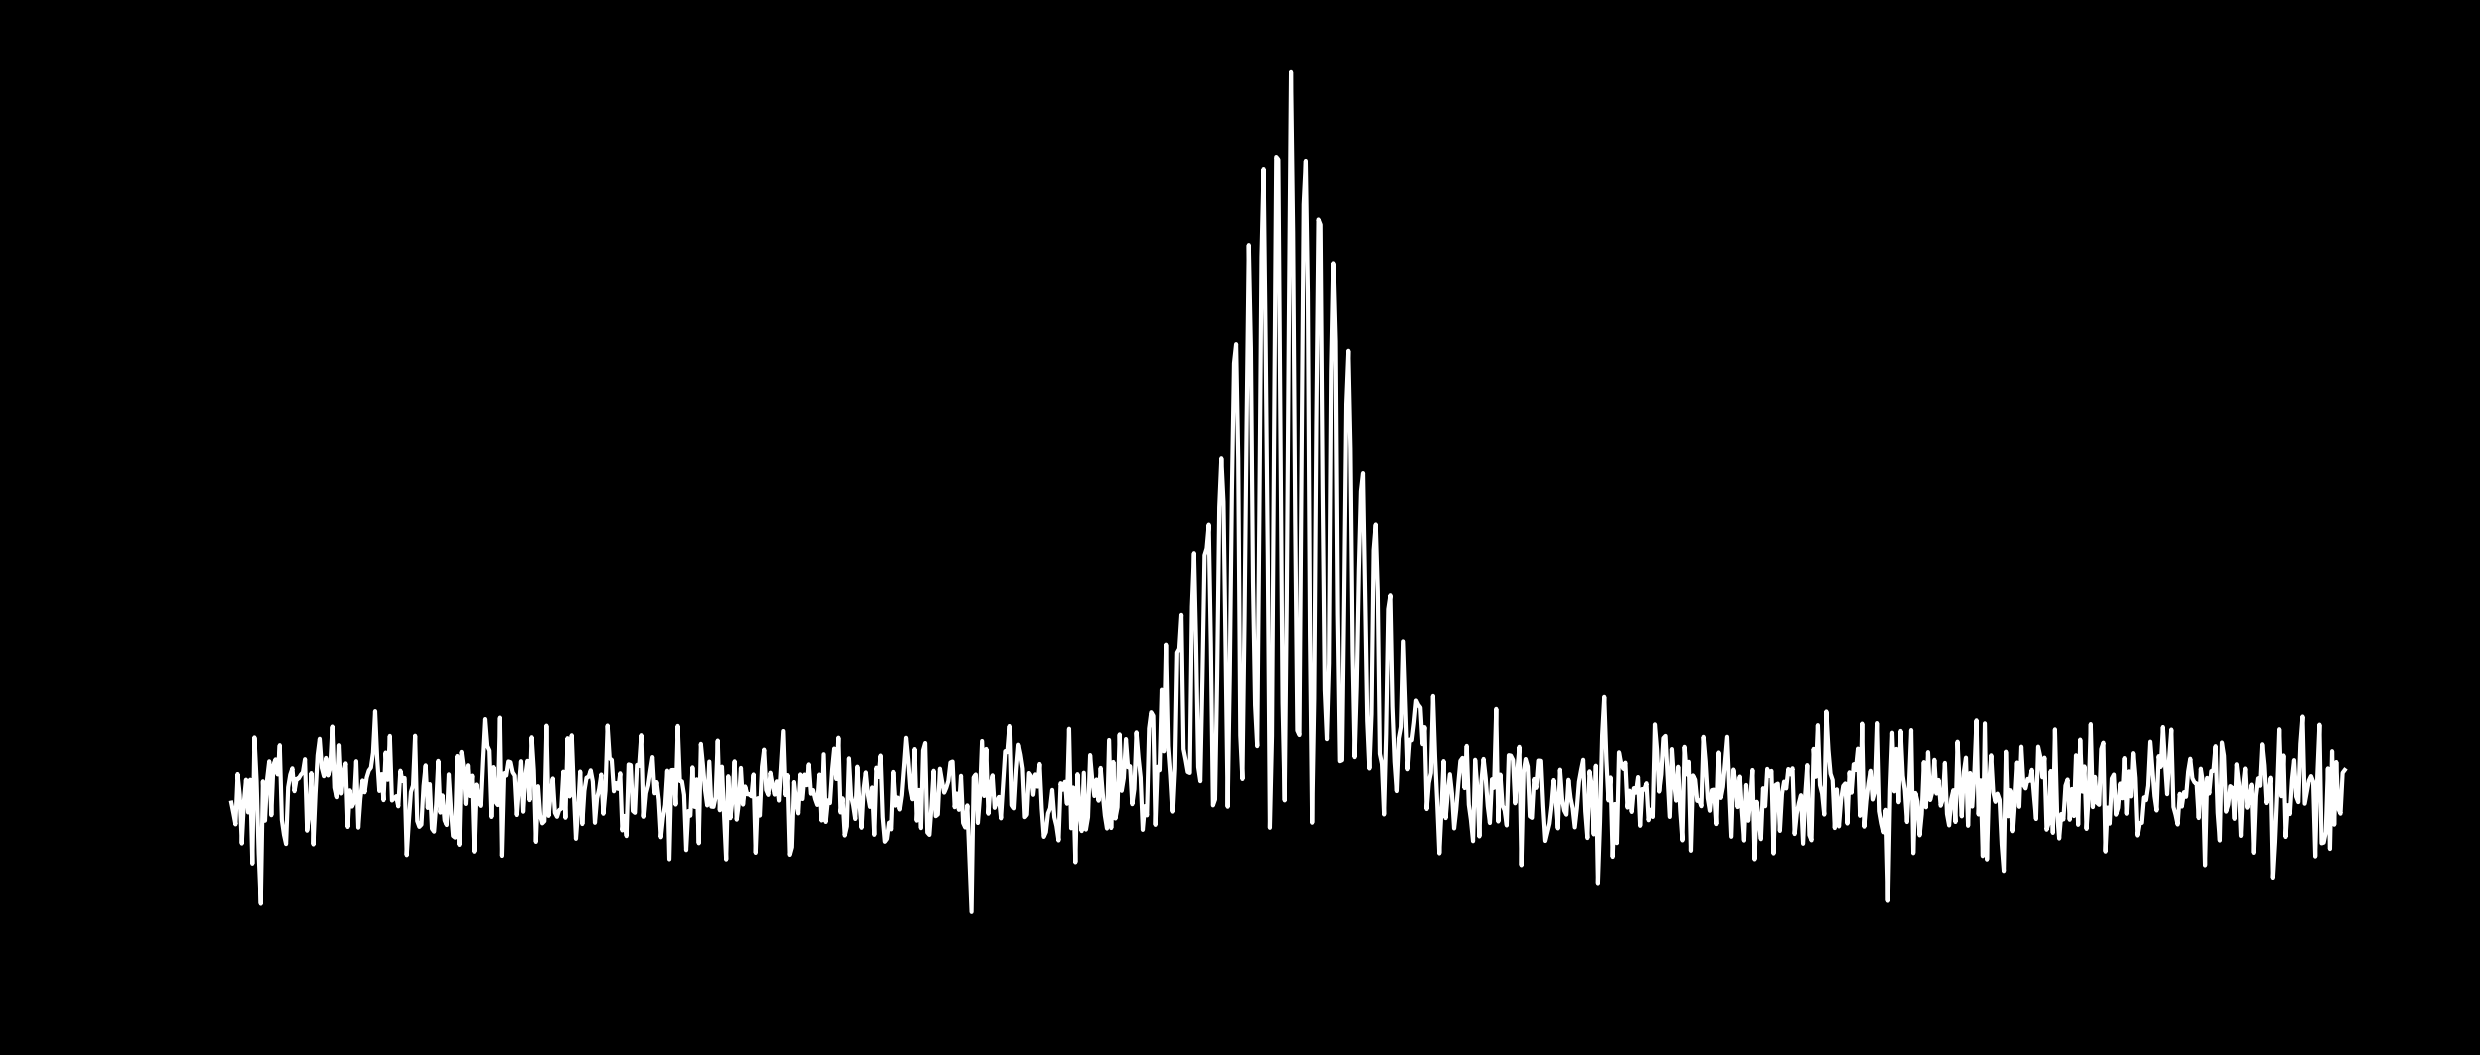

In [38]:
fig, ax = plt.subplots(figsize=(10,4), dpi=300)
ax.set_facecolor('black')
fig.patch.set_facecolor('black')

t, swr, _ = generate_sharp_wave_ripple()
ax.plot(t, swr, color='white', lw=1)
#fig.savefig('ripple.svg', transparent=True)

## Awake vs sleep

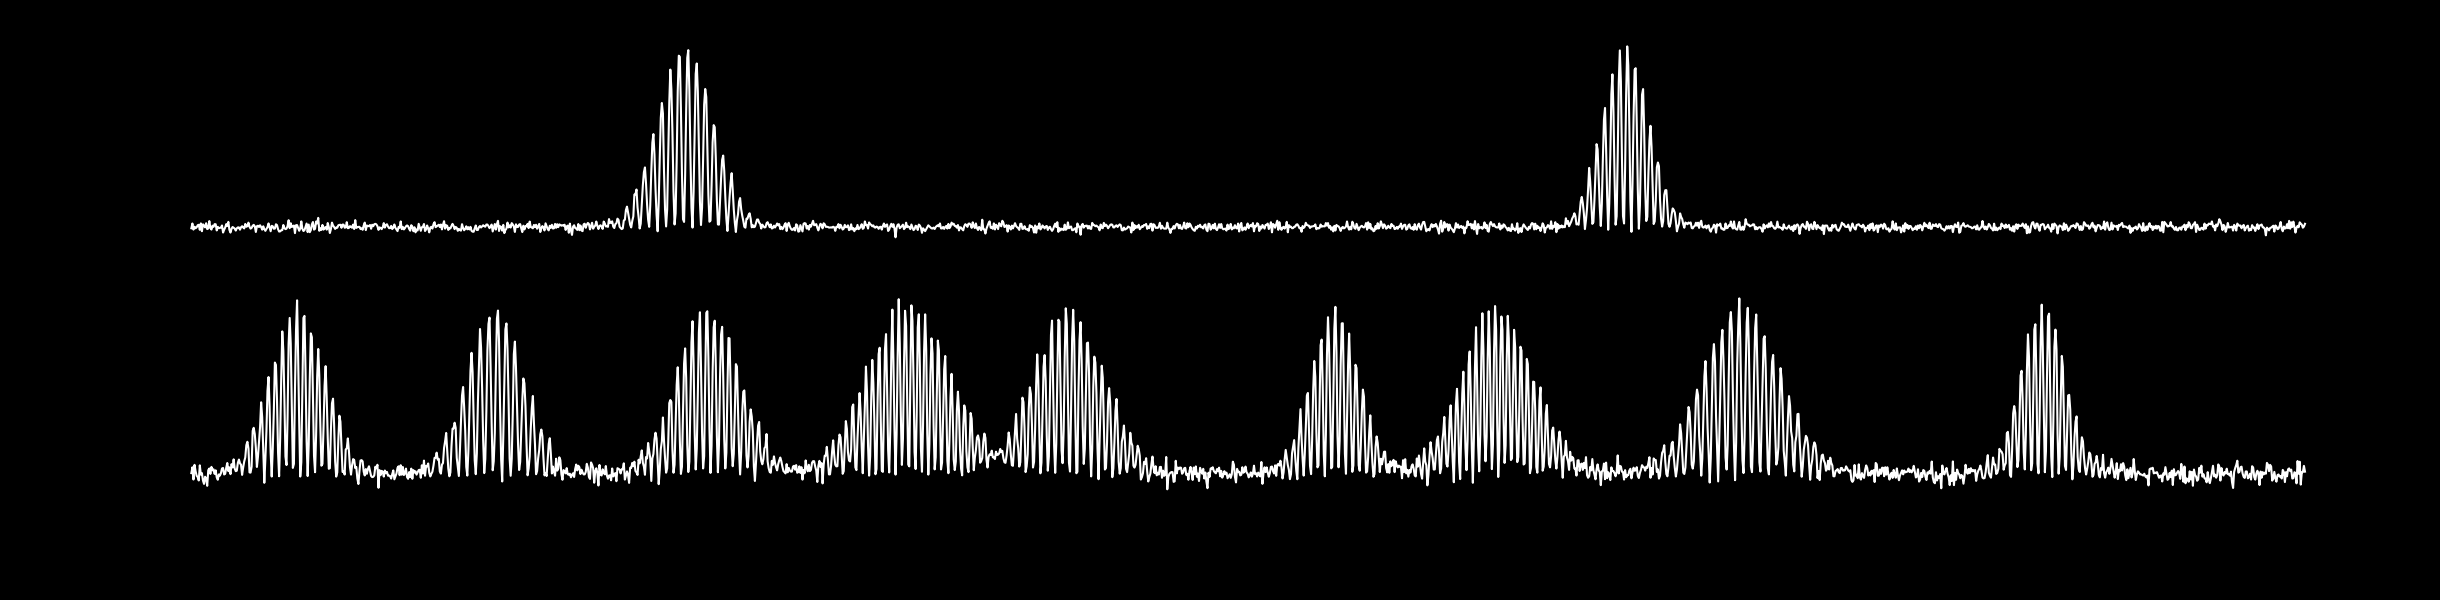

In [57]:
duration = 2 
n_events_sleep = 9
n_events_wake = 2
min_spacing = 0.02  # 20ms minimum spacing

t, signal_wake, _ = generate_dense_swrs(
    n_events=n_events_wake,
    duration=duration,
    min_spacing=0.2
)

t, signal_sleep, _ = generate_dense_swrs(
    n_events=n_events_sleep,
    duration=duration,
    min_spacing=0.02
)

fig, axs = plt.subplots(2, 1, figsize=(10,2), dpi=300)
fig.patch.set_facecolor('black')
axs[0].set_facecolor('black')
axs[1].set_facecolor('black')

axs[0].plot(t, signal_wake, color='white', lw=0.5)
axs[1].plot(t, signal_sleep, color='white', lw=0.5)

fig.savefig('sleep_vs_wake_swr.svg', transparent=True)